In [1]:
import gzip
import json
import pickle
import os
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from unidecode import unidecode

import numpy as np
import pandas as pd
import pyomo.environ as pyo
from loguru import logger
from pyomo.opt import TerminationCondition

from ppgmne_prf.config.paths import PATH_DATA_SOLVER_DETAILS, PATH_DATA_SOLVER_RESULTS, PATH_DATA_IBGE_UF, PATH_DATA_CACHE
from ppgmne_prf.utils import get_distance_matrix
from ppgmne_prf.load_data import load_data
from ppgmne_prf.preprocess import preprocess
from ppgmne_prf.utils import clean_string
from ppgmne_prf.optim import (get_abstract_model, get_fixed_params,
                              get_instance, get_solution_data, solve_instance)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['figure.figsize'] = [15, 8]

PALETTE = 'deep'
sns.set_palette(PALETTE)

In [2]:
# Funções úteis:

def get_df_results(df_results, p=None, q=None):
    if p is None:
        df_out = df_results[(df_results['q'] == q)].copy()
    if q is None:
        df_out = df_results[(df_results['p'] == p)].copy()
    df_out['obj_function_abs_diff'] = abs(df_out['obj_function'].diff().fillna(0))
    df_out['obj_function_abs_pct_change'] = abs(df_out['obj_function'].pct_change().fillna(0))*100
    df_out['obj_function_abs_pct_change'] = np.where(
        df_out['obj_function_abs_pct_change'] == 0, 
        np.nan, 
        df_out['obj_function_abs_pct_change']
    )
    return df_out

def get_solution_details(q, p):
    model_name = f'model_p{p}_q{q}_details'
    with gzip.open(PATH_DATA_SOLVER_DETAILS / f"{model_name}.gz", "rb") as f:
            df_out = pickle.load(f)
    return df_out

In [3]:
# Carrega as informações dos municípios (IBGE)

df_muns = pd.read_pickle(PATH_DATA_CACHE / "df_municipios_ibge.pkl")

cols = ['municipio', 'microrregiao', 'mesorregiao', 'regiao_imediata']
cols_en = ['municipality', 'microregion', 'mesoregion', 'immediate_region', ]
df_muns = df_muns[cols].copy()

for col in cols:
    df_muns = clean_string(df=df_muns, target=col, mode='upper')

df_muns.columns = cols_en
df_muns.head()

,municipality,microregion,mesoregion,immediate_region
0,ABATIA,CORNELIO PROCOPIO,NORTE PIONEIRO PARANAENSE,SANTO ANTONIO DA PLATINA
1,ADRIANOPOLIS,CERRO AZUL,METROPOLITANA DE CURITIBA,CURITIBA
2,AGUDOS DO SUL,RIO NEGRO,METROPOLITANA DE CURITIBA,CURITIBA
3,ALMIRANTE TAMANDARE,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA
4,ALTAMIRA DO PARANA,GOIOERE,CENTRO OCIDENTAL PARANAENSE,CAMPO MOURAO


In [4]:
# Carrega os dados pré-modelagem:

df_accidents, dict_stations = load_data()
df_quadrants = preprocess(df_accidents, dict_stations)
df_quadrants.head()

2023-07-04 06:36:48.019 | INFO     | ppgmne_prf.load_data:load_data:16 - Load data - Início do carregamento os dados de entrada.
2023-07-04 06:36:48.021 | INFO     | ppgmne_prf.load_data:load_data:18 - Load data (accidents) - Carregando os dados históricos dos acidentes.
2023-07-04 06:36:48.030 | WARNING  | ppgmne_prf.load_data:__load_accidents:44 - Load data (accidents) - Dados carregados da cache.
2023-07-04 06:36:48.063 | INFO     | ppgmne_prf.load_data:load_data:21 - Load data (stations) - Carregando as coordenadas das UOPs e delegacias.
2023-07-04 06:36:48.063 | WARNING  | ppgmne_prf.load_data:__load_stations:133 - Load data (stations) - Dados carregados da cache.
2023-07-04 06:36:48.064 | INFO     | ppgmne_prf.load_data:load_data:26 - Load data - Fim do carregamento os dados de entrada.
2023-07-04 06:36:48.065 | INFO     | ppgmne_prf.preprocess:preprocess:37 - Pre-process - Início do pré-processamento dos dados de entrada.
2023-07-04 06:36:48.065 | INFO     | ppgmne_prf.preproces

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster,dist_max,is_uop,is_only_uop
0,-24.9000,-49.1000,ADRIANOPOLIS,ADRIANOPOLIS 01,2.0000,0.0000,0.0000,1.0000,0.0000,1,180.0000,False,False
1,-23.1000,-52.3000,ALTO PARANA,ALTO PARANA 01,4.0000,1.0000,1.0000,1.0000,0.0000,1,180.0000,False,False
2,-23.1000,-50.2000,ANDIRA,ANDIRA 01,5.0000,0.0000,1.0000,3.0000,1.0000,1,180.0000,False,False
3,-23.0000,-50.2000,ANDIRA,ANDIRA 02,9.0000,0.0000,3.0000,5.0000,0.0000,2,180.0000,False,False
4,-25.9000,-50.2000,ANTONIO OLINTO,ANTONIO OLINTO 01,6.0000,0.0000,0.0000,1.0000,1.0000,1,180.0000,False,False


In [5]:
# Cria tabela com informações cadastrais por UOP:

df_uops = df_quadrants[['name', 'municipality', 'is_uop', 'n_accidents']].copy()
df_uops = df_uops.merge(df_muns, how='left', on='municipality')
df_uops.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region
0,ADRIANOPOLIS 01,ADRIANOPOLIS,False,2.0000,CERRO AZUL,METROPOLITANA DE CURITIBA,CURITIBA
1,ALTO PARANA 01,ALTO PARANA,False,4.0000,PARANAVAI,NOROESTE PARANAENSE,PARANAVAI
2,ANDIRA 01,ANDIRA,False,5.0000,CORNELIO PROCOPIO,NORTE PIONEIRO PARANAENSE,SANTO ANTONIO DA PLATINA
3,ANDIRA 02,ANDIRA,False,9.0000,CORNELIO PROCOPIO,NORTE PIONEIRO PARANAENSE,SANTO ANTONIO DA PLATINA
4,ANTONIO OLINTO 01,ANTONIO OLINTO,False,6.0000,SAO MATEUS DO SUL,SUDESTE PARANAENSE,UNIAO DA VITORIA


In [6]:
df_uops.isna().sum()

name                0
municipality        0
is_uop              0
n_accidents         2
microregion         0
mesoregion          0
immediate_region    0
dtype: int64

In [7]:
# Carrega os resultados:
output_dict = None

for file in os.listdir(PATH_DATA_SOLVER_RESULTS):
    
    if file.split(".")[-1] == "json":

        with open(PATH_DATA_SOLVER_RESULTS / file) as file:
            dict_result = json.load(file)

        if output_dict is None:
            output_dict = dict_result
            for key in dict_result:
                output_dict[key] = [dict_result[key]]

        else:
            for key in dict_result:
                output_dict[key].append(dict_result[key])

df_results = pd.DataFrame(output_dict)
df_results = df_results.sort_values(['p', 'q']).reset_index(drop=True)
df_results.head()

,name,p,q,solver,is_feasible,is_optimal,obj_function
0,model_p1_q0_results,1,0,gurobi,False,False,0.0000
1,model_p2_q0_results,2,0,gurobi,False,False,0.0000
2,model_p3_q0_results,3,0,gurobi,False,False,0.0000
3,model_p4_q0_results,4,0,gurobi,False,False,0.0000
4,model_p5_q0_results,5,0,gurobi,True,True,258845.2086


In [8]:
df_results.shape

(2153, 7)

In [9]:
# Somente soluções factíveis:

df_feasibles = df_results[df_results['is_feasible'] == True].copy()
df_feasibles.head()

,name,p,q,solver,is_feasible,is_optimal,obj_function
4,model_p5_q0_results,5,0,gurobi,True,True,258845.2086
5,model_p5_q1_results,5,1,gurobi,True,True,260245.6693
6,model_p5_q2_results,5,2,gurobi,True,True,264478.6044
7,model_p5_q3_results,5,3,gurobi,True,True,299508.8710
9,model_p6_q0_results,6,0,gurobi,True,True,224390.4451


In [10]:
df_feasibles.shape

(2119, 7)

In [11]:
df_feasibles.groupby(['p']).agg(min=('q', 'min'), max=('q', 'max')).reset_index()

,p,min,max
0,5,0,3
1,6,0,4
2,7,0,5
3,8,0,6
4,9,0,7
5,10,0,8
6,11,0,9
7,12,0,10
8,13,0,11
9,14,0,12


In [12]:
p = [p for p in range(5,81)]
q = [q for q in range(4, 35)] + [34]*45

df_check = pd.DataFrame({'p': p, 'n_sols': q})
df_check['n_sols'].sum()

2119

In [13]:
# Soluçòes livres

df_results_q0 = get_df_results(df_results, q=0)
df_results_q0

,name,p,q,solver,is_feasible,is_optimal,obj_function,obj_function_abs_diff,obj_function_abs_pct_change
0,model_p1_q0_results,1,0,gurobi,False,False,0.0000,0.0000,NaN
1,model_p2_q0_results,2,0,gurobi,False,False,0.0000,0.0000,NaN
2,model_p3_q0_results,3,0,gurobi,False,False,0.0000,0.0000,NaN
3,model_p4_q0_results,4,0,gurobi,False,False,0.0000,0.0000,NaN
4,model_p5_q0_results,5,0,gurobi,True,True,258845.2086,258845.2086,inf
9,model_p6_q0_results,6,0,gurobi,True,True,224390.4451,34454.7635,13.3110
15,model_p7_q0_results,7,0,gurobi,True,True,199217.6242,25172.8210,11.2183
22,model_p8_q0_results,8,0,gurobi,True,True,184799.7522,14417.8720,7.2372
30,model_p9_q0_results,9,0,gurobi,True,True,171943.0278,12856.7244,6.9571
39,model_p10_q0_results,10,0,gurobi,True,True,161623.5457,10319.4821,6.0017


In [14]:
def plot_fo(
    df_plot,
    x_param,
    xtick_min=0,
    xtick_max=80,
    xtick_multiple=2,
    p2_ytick_max=15,
    pct_cutover=3,
    x_cutover=None,
    xlabel='Número de UOPs a serem instaladas (p)',
    p1_ylabel='Função Objetivo (Z)',
    p2_ylabel='Decrescimento Percentual de Z',
    fontsize=14,
    figsize=(15,8),
    invert_x=False,
    palette=sns.color_palette(PALETTE),
    arrow_txt="p = 29",
    arrow_xy=(28.9, 2.7),
    arrow_txt_xy=(15, 1),
    only_feasible=False):

    if only_feasible:
        df_plot = df_plot[df_plot['is_feasible'] == True]

    plt.subplots(figsize=figsize)

    p1 = sns.lineplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    sns.scatterplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    p1.set_xlabel(xlabel,fontsize=fontsize)
    p1.set_ylabel(p1_ylabel, color=palette[0], fontsize=fontsize)

    p2 = p1.twinx()
    sns.lineplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    sns.scatterplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    p2.set_yticks(range(0, p2_ytick_max+1, 1))
    p2.set_ylabel(p2_ylabel, color=palette[1], fontsize=fontsize)

    if pct_cutover is not None:
        plt.axhline(y=pct_cutover, color=palette[7], linestyle='--')

    if x_cutover is not None:
        plt.axvline(x=x_cutover, color=palette[7], linestyle='--')

    if invert_x:
        plt.gca().invert_xaxis()

    if arrow_txt is not None:
        plt.annotate(arrow_txt, xy=arrow_xy, xytext=arrow_txt_xy, arrowprops={'arrowstyle': "->"})

    plt.xticks(range(xtick_min, xtick_max+1, xtick_multiple))
    plt.savefig('foo.png')   
    plt.show()

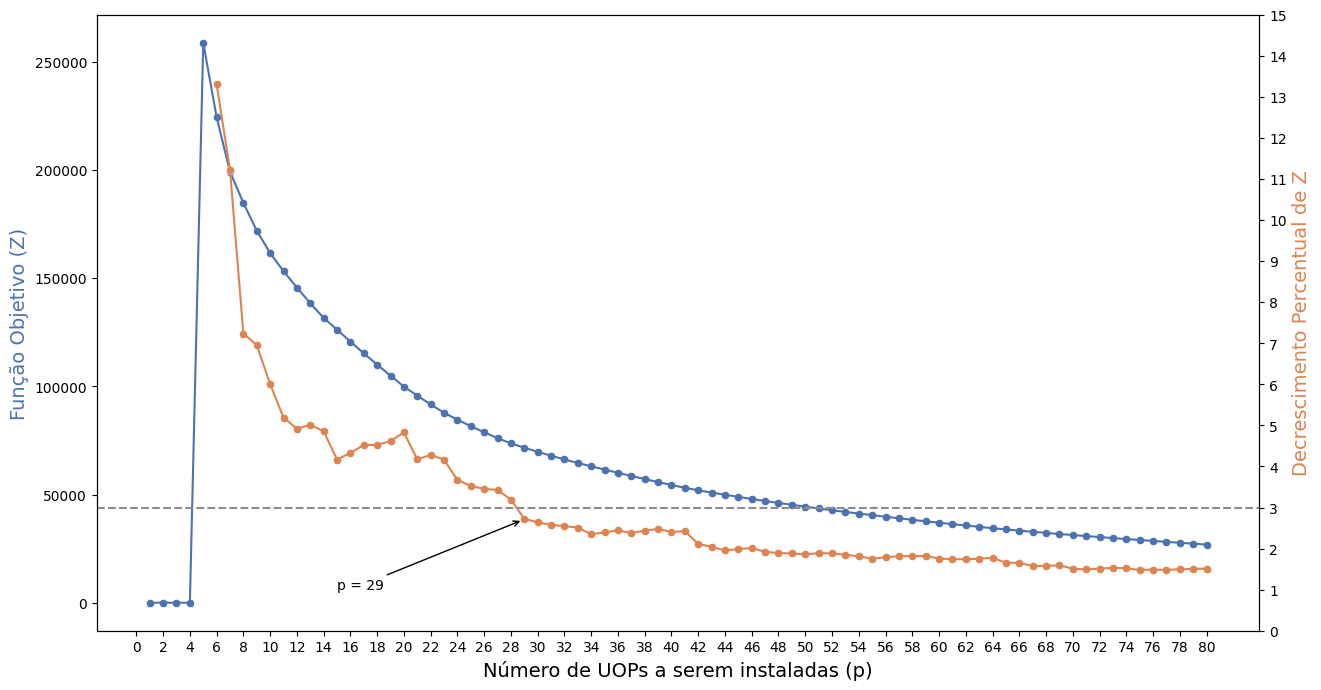

In [15]:
plot_fo(df_results_q0, "p")

In [16]:
df_results_q0

,name,p,q,solver,is_feasible,is_optimal,obj_function,obj_function_abs_diff,obj_function_abs_pct_change
0,model_p1_q0_results,1,0,gurobi,False,False,0.0000,0.0000,NaN
1,model_p2_q0_results,2,0,gurobi,False,False,0.0000,0.0000,NaN
2,model_p3_q0_results,3,0,gurobi,False,False,0.0000,0.0000,NaN
3,model_p4_q0_results,4,0,gurobi,False,False,0.0000,0.0000,NaN
4,model_p5_q0_results,5,0,gurobi,True,True,258845.2086,258845.2086,inf
9,model_p6_q0_results,6,0,gurobi,True,True,224390.4451,34454.7635,13.3110
15,model_p7_q0_results,7,0,gurobi,True,True,199217.6242,25172.8210,11.2183
22,model_p8_q0_results,8,0,gurobi,True,True,184799.7522,14417.8720,7.2372
30,model_p9_q0_results,9,0,gurobi,True,True,171943.0278,12856.7244,6.9571
39,model_p10_q0_results,10,0,gurobi,True,True,161623.5457,10319.4821,6.0017


In [17]:
# Verifica a distribuição das UOPs por solução:

dict_sols = {'p': [], 'q': [], 'name': []}

for row in df_feasibles.itertuples():
    df_sol = get_solution_details(p=row.p, q=row.q)
    uops = list(df_sol[df_sol['is_median'] == 1]['name'])
    dict_sols['p'] = dict_sols['p'] + [row.p]*len(uops)
    dict_sols['q'] = dict_sols['q'] + [row.q]*len(uops)
    dict_sols['name'] = dict_sols['name'] + uops

In [18]:
df_uops_sols = pd.DataFrame(dict_sols)
df_uops_sols.head()

,p,q,name
0,5,0,CAPITAO LEONIDAS MARQUES 02
1,5,0,CURITIBA 04
2,5,0,IMBITUVA 04
3,5,0,LONDRINA 03
4,5,0,MARINGA 02


In [19]:
df_uops_sols.shape

(101315, 3)

In [20]:
p = 29
range_p = [p for p in range(p, 41+1)]
print(range_p)
print(len(range_p))
df_uops_sols_range = df_uops_sols[df_uops_sols['p'].isin(range_p)].copy()
df_uops_sols_range.head()

[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
13


,p,q,name
7045,29,0,ANDIRA 01
7046,29,0,APUCARANA 01
7047,29,0,UOP06-DEL01-PR
7048,29,0,CAMPINA GRANDE DO SUL 05
7049,29,0,CANTAGALO 01


In [21]:
def agg_uops(df, p=None, q=None):
    if p is not None:
        df = df[df['p'] == p].copy()
    if q is not None:
        df = df[df['q'] == q].copy()
    df_out = df.groupby('name').agg(n=('name', 'count')).reset_index()
    return df_out

df_uops_agg_range = agg_uops(df_uops_sols_range)
df_uops_agg_range.head()

,name,n
0,ANDIRA 01,58
1,APUCARANA 01,273
2,ARAPONGAS 01,68
3,ARAPONGAS 02,145
4,BARRACAO 04,139


In [22]:
def merge_uops(df, df_agg):
    df_out = df.merge(df_agg, how='left', on='name')
    df_out['n'] = df_out['n'].fillna(0)
    df_out = df_out.sort_values(by='n', ascending=False).reset_index(drop=True)
    return df_out

df_uops_all_range = merge_uops(df_uops, df_uops_agg_range)
df_uops_all_range.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,n
0,TIBAGI 03,TIBAGI,False,41.0000,TELEMACO BORBA,CENTRO ORIENTAL PARANAENSE,TELEMACO BORBA,421.0000
1,CURITIBA 03,CURITIBA,False,299.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,414.0000
2,MARINGA 02,MARINGA,False,142.0000,MARINGA,NORTE CENTRAL PARANAENSE,MARINGA,406.0000
3,CASCAVEL 02,CASCAVEL,False,68.0000,CASCAVEL,OESTE PARANAENSE,CASCAVEL,397.0000
4,FOZ DO IGUACU 04,FOZ DO IGUACU,False,80.0000,FOZ DO IGUACU,OESTE PARANAENSE,FOZ DO IGUACU,397.0000


In [23]:
def main_questions(df):
    r = df[df['n'] > 0].shape[0]
    print(f'Quantas UOPs aparecem em pelo menos 1 solução? R: {r}')

    r = df[(df['n'] > 0) & (df['is_uop'] == True)].shape[0]
    print(f'Destas, quantas são UOPs atuais? R: {r}')

    r = df[df['n'] == 0].shape[0]
    print(f'Quantas UOPs nunca apareceram numa solução? R: {r}')

    r = df[(df['n'] == 0) & (df['is_uop'] == True)].shape[0]
    print(f'Destas, quantas são UOPs atuais? R: {r}')

In [24]:
main_questions(df_uops_all_range)

Quantas UOPs aparecem em pelo menos 1 solução? R: 88
Destas, quantas são UOPs atuais? R: 12
Quantas UOPs nunca apareceram numa solução? R: 268
Destas, quantas são UOPs atuais? R: 21


In [25]:
# Quando q = 0, ou seja, quando a solução está livre para alocar ou não uma UOP atual

df_uops_agg_range_q0 = agg_uops(df_uops_sols_range, q = 0)
df_uops_all_range_q0 = merge_uops(df_uops, df_uops_agg_range_q0)
df_uops_all_range_q0.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,n
0,GUARAPUAVA 08,GUARAPUAVA,False,21.0000,GUARAPUAVA,CENTRO-SUL PARANAENSE,GUARAPUAVA,13.0000
1,CURITIBA 01,CURITIBA,False,200.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,13.0000
2,CASCAVEL 02,CASCAVEL,False,68.0000,CASCAVEL,OESTE PARANAENSE,CASCAVEL,13.0000
3,SAO JOSE DOS PINHAIS 05,SAO JOSE DOS PINHAIS,False,126.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,13.0000
4,MARECHAL CANDIDO RONDON 02,MARECHAL CANDIDO RONDON,False,16.0000,TOLEDO,OESTE PARANAENSE,MARECHAL CANDIDO RONDON,13.0000


In [26]:
n_total = df_feasibles[(df_feasibles['q'] == 0) & (df_feasibles['p'].isin(range_p))].shape[0]
n_total

13

In [27]:
df_uops_all_range_q0['pct_solutions'] = df_uops_all_range_q0['n'] / n_total * 100
df_uops_all_range_q0.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,n,pct_solutions
0,GUARAPUAVA 08,GUARAPUAVA,False,21.0000,GUARAPUAVA,CENTRO-SUL PARANAENSE,GUARAPUAVA,13.0000,100.0000
1,CURITIBA 01,CURITIBA,False,200.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,13.0000,100.0000
2,CASCAVEL 02,CASCAVEL,False,68.0000,CASCAVEL,OESTE PARANAENSE,CASCAVEL,13.0000,100.0000
3,SAO JOSE DOS PINHAIS 05,SAO JOSE DOS PINHAIS,False,126.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,13.0000,100.0000
4,MARECHAL CANDIDO RONDON 02,MARECHAL CANDIDO RONDON,False,16.0000,TOLEDO,OESTE PARANAENSE,MARECHAL CANDIDO RONDON,13.0000,100.0000


In [28]:
df_uops_all_range_q0_current = df_uops_all_range_q0[df_uops_all_range_q0['is_uop'] == True].copy()
df_uops_all_range_q0_current.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,n,pct_solutions
5,UOP04-DEL01-PR,GUARATUBA,True,41.0000,PARANAGUA,METROPOLITANA DE CURITIBA,PARANAGUA,13.0000,100.0000
8,UOP04-DEL02-PR,SAO MATEUS DO SUL,True,25.0000,SAO MATEUS DO SUL,SUDESTE PARANAENSE,UNIAO DA VITORIA,13.0000,100.0000
15,UOP05-DEL01-PR,PARANAGUA,True,51.0000,PARANAGUA,METROPOLITANA DE CURITIBA,PARANAGUA,13.0000,100.0000
16,UOP02-DEL09-PR,PARANAVAI,True,13.0000,PARANAVAI,NOROESTE PARANAENSE,PARANAVAI,13.0000,100.0000
18,UOP01-DEL02-PR,PATO BRANCO,True,35.0000,PATO BRANCO,SUDOESTE PARANAENSE,PATO BRANCO,13.0000,100.0000


In [29]:
df_uops_all_range_q0_current.shape

(33, 9)

In [30]:
df_tb_current = df_uops_all_range_q0_current[df_uops_all_range_q0_current['n'] > 0].sort_values(by=['pct_solutions', 'municipality'], ascending=[False, True]).reset_index(drop=True)
df_tb_current

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,n,pct_solutions
0,UOP04-DEL01-PR,GUARATUBA,True,41.0000,PARANAGUA,METROPOLITANA DE CURITIBA,PARANAGUA,13.0000,100.0000
1,UOP05-DEL01-PR,PARANAGUA,True,51.0000,PARANAGUA,METROPOLITANA DE CURITIBA,PARANAGUA,13.0000,100.0000
2,UOP02-DEL09-PR,PARANAVAI,True,13.0000,PARANAVAI,NOROESTE PARANAENSE,PARANAVAI,13.0000,100.0000
3,UOP01-DEL02-PR,PATO BRANCO,True,35.0000,PATO BRANCO,SUDOESTE PARANAENSE,PATO BRANCO,13.0000,100.0000
4,UOP04-DEL02-PR,SAO MATEUS DO SUL,True,25.0000,SAO MATEUS DO SUL,SUDESTE PARANAENSE,UNIAO DA VITORIA,13.0000,100.0000
5,UOP06-DEL01-PR,BALSA NOVA,True,38.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,5.0000,38.4615


In [31]:
33-6

27

In [32]:
df_uops_all_range_q0_candidate = df_uops_all_range_q0[df_uops_all_range_q0['is_uop'] == False].copy()
df_uops_all_range_q0_candidate.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,n,pct_solutions
0,GUARAPUAVA 08,GUARAPUAVA,False,21.0000,GUARAPUAVA,CENTRO-SUL PARANAENSE,GUARAPUAVA,13.0000,100.0000
1,CURITIBA 01,CURITIBA,False,200.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,13.0000,100.0000
2,CASCAVEL 02,CASCAVEL,False,68.0000,CASCAVEL,OESTE PARANAENSE,CASCAVEL,13.0000,100.0000
3,SAO JOSE DOS PINHAIS 05,SAO JOSE DOS PINHAIS,False,126.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,13.0000,100.0000
4,MARECHAL CANDIDO RONDON 02,MARECHAL CANDIDO RONDON,False,16.0000,TOLEDO,OESTE PARANAENSE,MARECHAL CANDIDO RONDON,13.0000,100.0000


In [33]:
df_uops_all_range_q0_candidate.shape

(323, 9)

In [34]:
df_tb_candidate = df_uops_all_range_q0_candidate[df_uops_all_range_q0_candidate['n'] > 0].sort_values(by=['pct_solutions', 'municipality'], ascending=[False, True]).reset_index(drop=True)
df_tb_candidate

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,n,pct_solutions
0,APUCARANA 01,APUCARANA,False,32.0000,APUCARANA,NORTE CENTRAL PARANAENSE,APUCARANA,13.0000,100.0000
1,CASCAVEL 02,CASCAVEL,False,68.0000,CASCAVEL,OESTE PARANAENSE,CASCAVEL,13.0000,100.0000
2,CURITIBA 01,CURITIBA,False,200.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,13.0000,100.0000
3,CURITIBA 03,CURITIBA,False,299.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,13.0000,100.0000
4,CURITIBA 06,CURITIBA,False,179.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,13.0000,100.0000
5,FOZ DO IGUACU 04,FOZ DO IGUACU,False,80.0000,FOZ DO IGUACU,OESTE PARANAENSE,FOZ DO IGUACU,13.0000,100.0000
6,GUARAPUAVA 08,GUARAPUAVA,False,21.0000,GUARAPUAVA,CENTRO-SUL PARANAENSE,GUARAPUAVA,13.0000,100.0000
7,IRATI 02,IRATI,False,16.0000,IRATI,SUDESTE PARANAENSE,IRATI,13.0000,100.0000
8,MARECHAL CANDIDO RONDON 02,MARECHAL CANDIDO RONDON,False,16.0000,TOLEDO,OESTE PARANAENSE,MARECHAL CANDIDO RONDON,13.0000,100.0000
9,MARINGA 02,MARINGA,False,142.0000,MARINGA,NORTE CENTRAL PARANAENSE,MARINGA,13.0000,100.0000


In [35]:
df_tb_candidate.shape

(44, 9)

In [36]:
323 - 44

279

In [37]:
uops_to_plot = df_uops_all_range_q0[(df_uops_all_range_q0['pct_solutions'] > 0) & (df_uops_all_range_q0['pct_solutions'] < 100)].sort_values('n', ascending=False)['name']
uops_to_plot

21                ARAPONGAS 02
23                 CAPANEMA 02
24                 BARRACAO 04
22                  JURANDA 03
25     SAO JOSE DOS PINHAIS 03
26                CANTAGALO 01
27              MANDIRITUBA 02
28               GUARANIACU 01
29                 PALMEIRA 06
30    CAMPINA GRANDE DO SUL 03
31    CAMPINA GRANDE DO SUL 06
32                 LONDRINA 02
33              JACAREZINHO 01
37    CAMPINA GRANDE DO SUL 05
38                   ANDIRA 01
35        CORNELIO PROCOPIO 01
36                 LONDRINA 03
34                   IBAITI 02
39                   IBAITI 03
40               GUARANIACU 02
41              UOP06-DEL01-PR
42                   CANDOI 05
43         NOVA LARANJEIRAS 02
44                    IMBAU 02
45                PRANCHITA 01
46                  UBIRATA 04
47             CAMPO MOURAO 01
48              CAMPO LARGO 03
49                 MORRETES 02
Name: name, dtype: object

In [38]:
df_plot = df_uops_sols_range[(df_uops_sols_range['name'].isin(uops_to_plot)) & (df_uops_sols_range['q'] == 0)].copy()
df_plot.head()

,p,q,name
7045,29,0,ANDIRA 01
7047,29,0,UOP06-DEL01-PR
7048,29,0,CAMPINA GRANDE DO SUL 05
7049,29,0,CANTAGALO 01
7055,29,0,GUARANIACU 01


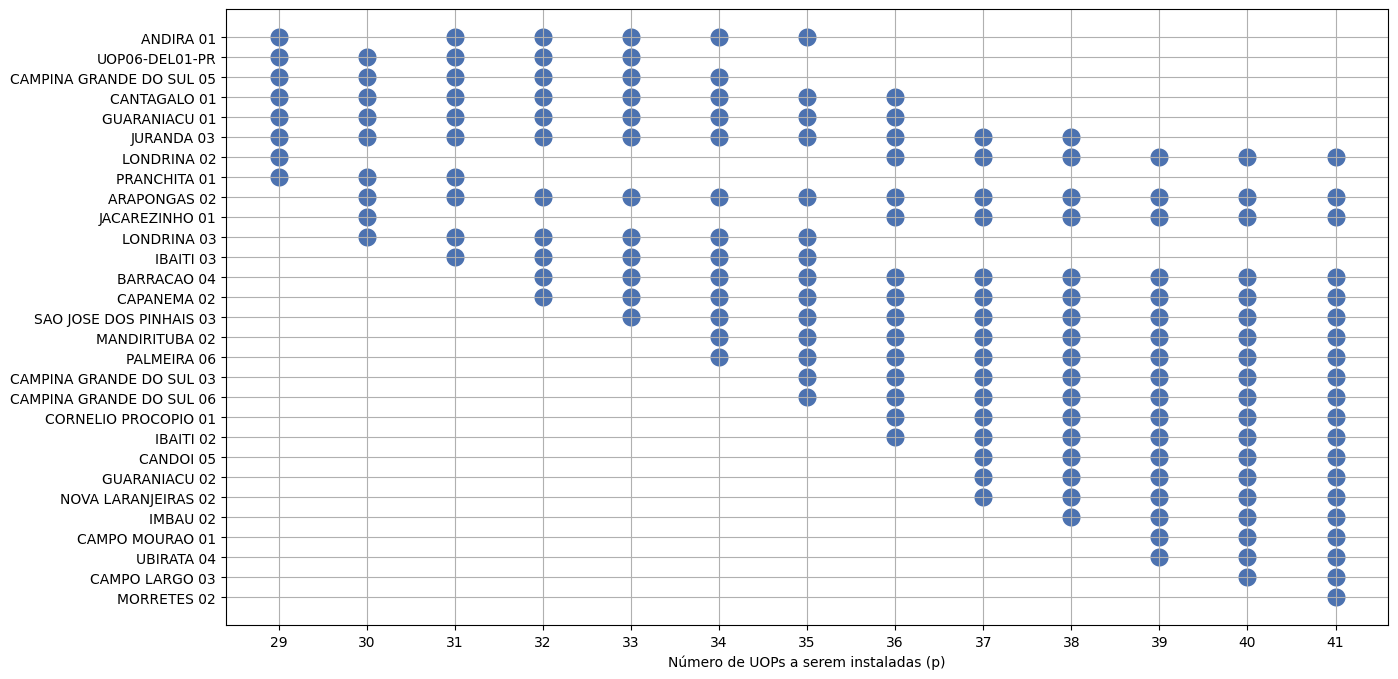

In [39]:
figsize=(15,8)

plt.subplots(figsize=figsize)

sns.scatterplot(df_plot, x='p', y='name', s=200)
plt.xticks(range_p)
plt.xlabel("Número de UOPs a serem instaladas (p)")
plt.ylabel("")
plt.grid()

In [ ]:
df_ = df_quadrants[df_quadrants['name'].isin(['UOP06-DEL01-PR', 'PALMEIRA 06', 'MANDIRITUBA 02'])].copy()
df_

In [ ]:
dist_matrix = get_distance_matrix(
    df_["latitude"], df_["longitude"], df_["latitude"], df_["longitude"]
)

dist_matrix

In [ ]:
# Verificar se trocando a UOP06-DEL01-PR POR PALMEIRA 06 muda muito a FO (a distância entre as duas é de 14,9km)
# Deste modo é possível garantir a expansão futura

In [ ]:
df_sol = get_solution_details(q=0, p=34)

In [ ]:
df_sol['obj_function'].sum()

In [ ]:
# FO: 3225.6863869439235
df_sol[df_sol['median_name'] == 'PALMEIRA 06']

In [ ]:
uops = df_sol[df_sol['median_name'] == 'PALMEIRA 06']['name']

In [ ]:
def compare_median_change(df_sol, median_from, median_to):

    def calculate_distances_to_median(df_median, median_name):
        lat_median = df_median[df_median['name'] == median_name]['latitude'].min()
        lon_median = df_median[df_median['name'] == median_name]['longitude'].min()
        dist_matrix = get_distance_matrix(
            df_median["latitude"], df_median["longitude"], [lat_median]*df_median.shape[0], [lon_median]*df_median.shape[0]
        )
        sum_dists = sum(dist_matrix.T[0])
        wsum_dists = sum(dist_matrix.T[0] * df_median['n_accidents'])
        return sum_dists, wsum_dists
    
    df_median = df_sol[df_sol['median_name'] == median_from].copy()

    sum_dist_from, wsum_dist_from = calculate_distances_to_median(df_median, median_from)
    sum_dist_to, wsum_dist_to = calculate_distances_to_median(df_median, median_to)

    print(f"Soma das distâncias para a mediana {median_from}: {sum_dist_from}")
    print(f"Soma das distâncias ponderadas para a mediana {median_from}: {wsum_dist_from}")
    print("")
    print(f"Soma das distâncias para a mediana {median_to}: {sum_dist_to}")
    print(f"Soma das distâncias ponderadas para a mediana {median_to}: {wsum_dist_to}")
    print("")
    print(f"Variação da soma das distâncias: {round((sum_dist_to - sum_dist_from)/sum_dist_from*100,2)}%")
    print(f"Variação da soma das distâncias ponderadas: {round((wsum_dist_to - wsum_dist_from)/wsum_dist_from*100,2)}%")


In [ ]:
compare_median_change(df_sol, median_from='PALMEIRA 06', median_to='UOP06-DEL01-PR')

In [ ]:
def plot_fo(
    df_plot,
    x_param,
    xtick_min=0,
    xtick_max=80,
    xtick_multiple=2,
    p2_ytick_max=15,
    pct_cutover=3,
    x_cutover=None,
    xlabel='Número de UOPs a serem instaladas (p)',
    p1_ylabel='Função Objetivo (Z)',
    p2_ylabel='Decrescimento Percentual de Z',
    fontsize=14,
    figsize=(15,8),
    invert_x=False,
    palette=sns.color_palette(PALETTE),
    arrow_txt="p = 29",
    arrow_xy=(28.9, 2.7),
    arrow_txt_xy=(15, 1),
    only_feasible=False):

    if only_feasible:
        df_plot = df_plot[df_plot['is_feasible'] == True]

    plt.subplots(figsize=figsize)

    p1 = sns.lineplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    sns.scatterplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    p1.set_xlabel(xlabel,fontsize=fontsize)
    p1.set_ylabel(p1_ylabel, color=palette[0], fontsize=fontsize)

    p2 = p1.twinx()
    sns.lineplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    sns.scatterplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    p2.set_yticks(range(0, p2_ytick_max+1, 1))
    p2.set_ylabel(p2_ylabel, color=palette[1], fontsize=fontsize)

    if pct_cutover is not None:
        plt.axhline(y=pct_cutover, color=palette[7], linestyle='--')

    if x_cutover is not None:
        plt.axvline(x=x_cutover, color=palette[7], linestyle='--')

    if invert_x:
        plt.gca().invert_xaxis()

    if arrow_txt is not None:
        plt.annotate(arrow_txt, xy=arrow_xy, xytext=arrow_txt_xy, arrowprops={'arrowstyle': "->"})

    plt.xticks(range(xtick_min, xtick_max+1, xtick_multiple))
    plt.savefig('foo.png')   
    plt.show()

In [ ]:
plot_fo(df_results_q0, "p")

In [ ]:
df_results_p29 = get_df_results(df_results, p=29)
df_results_p29 = df_results_p29.sort_values('q', ascending=False).reset_index(drop=True)
df_results_p29['obj_function_abs_diff'] = df_results_p29['obj_function'].diff().abs()
df_results_p29['obj_function_abs_pct_change'] = df_results_p29['obj_function'].pct_change().abs() * 100

In [ ]:
df_results_p29

In [ ]:
plot_fo(
    df_results_p29, 
    "q",
    xtick_min=0,
    xtick_max=29,
    xtick_multiple=1,
    p2_ytick_max=20,
    pct_cutover=None,
    x_cutover=24,
    only_feasible=True,
    arrow_txt=None,
    xlabel="Número mínimo de UOPs a serem mantidas (q)",
    p2_ylabel="Crescimento Percentual de Z"
    
)

In [ ]:
def get_solution_details(q, p):
    model_name = f'model_p{p}_q{q}_details'
    with gzip.open(PATH_DATA_SOLVER_DETAILS / f"{model_name}.gz", "rb") as f:
            df_out = pickle.load(f)
    return df_out

In [ ]:
df_q0_p34 = get_solution_details(0, 34)
df_q0_p42 = get_solution_details(0, 42)

df_a = df_q0_p34[df_q0_p34['is_median']].copy()
df_b = df_q0_p42[df_q0_p42['is_median']].copy()

# dist_matrix = get_distance_matrix(
#         lat_rows=df_a['latitude'], 
#         lon_rows=df_a['longitude'], 
#         lat_cols=df_b['latitude'], 
#         lon_cols=df_b['longitude'])

# vlr_dist = sum(dist_matrix.min(axis=1))

In [ ]:
df_shape = gpd.read_file(PATH_DATA_IBGE_UF / 'PR_Municipios_2019.shp')
MAP_COLOR = '#d1cab2'

In [ ]:
df_a.head()

In [ ]:
df_concat = pd.concat([df_a, df_b], ignore_index=True)
df_agg = df_concat.groupby(['name']).agg(n=('name', 'count')).reset_index()
df_agg['label'] = np.where(df_agg['n'] == 2, 'ambas', 'verificar')

In [ ]:
df_b = df_b.merge(df_agg, how='left', on='name')
df_b = df_b[df_b['label'] == 'verificar'].copy()
df_b['label'] = 'b'

In [ ]:
df_a = df_a.merge(df_agg, how='left', on='name')
df_a['label'] = np.where(df_a['label'] == 'verificar', 'a', 'a/b')

In [ ]:
df_concat = pd.concat([df_a, df_b], ignore_index=True)

In [ ]:
df_concat.head()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
df_shape.plot(ax = ax, color = MAP_COLOR)

sns.scatterplot(data=df_a, x='longitude', y='latitude', alpha=0.6)
sns.scatterplot(data=df_b, x='longitude', y='latitude', alpha=0.5)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
df_shape.plot(ax = ax, color = MAP_COLOR)

sns.scatterplot(df_concat, x='longitude', y='latitude', hue='label')

In [ ]:
p = 34
df_results_p34 = df_results[(df_results['p'] == p) & (df_results['is_feasible']) & (df_results['p'] <= 60)].copy()
df_results_p34['obj_function_abs_diff'] = abs(df_results_p34['obj_function'].diff().fillna(0))
df_results_p34['obj_function_abs_pct_change'] = abs(df_results_p34['obj_function'].pct_change().fillna(0))*100

In [ ]:
plot_obj(
    df_results_p34, 
    "q", 
    'Número de UOPs atuais (q)', 
    'Função Objetivo (Z)', 
    'Decrescimento de Z (%)',
    [18,29, 10],
    x_scale=1,
    x_inverse=True,)